# Population-based training

An individual in the population consists of a set of hyperparameters (we want to find the best such hyperparameters along the way) and a model (a state that changes throughout training). We can train an individual and receive a performance evaluation.
Now and then, when we can decide to compare an individual to the remainder of the population and depending on the result, we can decide to exploit other individuals (by copying over their model or their hyperparameters) and/or to explore our hyperparameters.

Note: Exploitation of model and hyperparameters separately requires that models for different hyperparameters are compatible with each other.


# First API iteration

In [ ]:
import abc
import typing

class Individual(abc.ABC):   
    @abc.abstractmethod
    def step(self):
        pass
    
    @property
    @abc.abstractmethod
    def performance(self) -> float:
        pass

    @property
    @abc.abstractmethod
    def is_ready(self) -> bool:
        pass
    
    @abc.abstractmethod
    def explore(self):
        pass
    
    @abc.abstractmethod
    def exploit(self, population: 'Population'):
        pass
    
    
class Population(abc.ABC):
    @property
    @abc.abstractmethod
    def individuals(self) -> typing.List[Individual]:
        pass
    
    @abc.abstractmethod
    def is_underperformer(self, individual: Individual) -> bool:
        pass
          
    def evolve(self, num_steps):
        for _ in range(num_steps):
            for individual in self.individuals:
                individual.step()
                if individual.is_ready() and population.is_underperformer(individual):
                    individual.exploit(population)
                    individual.explore()
        
                

## Critique

* Individual steps prevent batching of steps across the population
* What about early stopping?
* The workers=2 example makes it hard to break symmetries

In [256]:
import numpy as np


class HistoryItem(typing.NamedTuple):
    loss: np.ndarray
    theta: np.ndarray
    h: np.ndarray


def format_with__dict__(instance: object):
    """Format all the fields of an object."""
    object_class = instance.__class__
    return '%s.%s(%s)' % (object_class.__module__, object_class.__name__,
                          ','.join([
                              '%s=%r' % (name, value)
                              for name, value in instance.__dict__.items()
                          ]))


class ExampleIndividual(Individual):
    learning_rate = 0.01
    exploration_scale = 0.1

    def __init__(self, theta, h):
        self.theta = np.copy(theta)
        self.h = np.copy(h)
        self.steps = 0
        self.history = []

    def __repr__(self):
        return format_with__dict__(self)

    @property
    def surrogate(self):
        return 1.2 - np.dot(np.maximum(self.h, 0.), self.theta**2)

    @property
    def performance(self):
        return 1.2 - np.dot(self.theta, self.theta)

    def step(self):
        #if self.steps % 4 == 0:
        self.history.append(
            HistoryItem(self.performance, np.copy(self.theta),
                        np.copy(self.h)))

        dtheta = -2 * self.h * self.theta
        self.theta += self.learning_rate * dtheta
        self.steps += 1

    def is_ready(self):
        return self.steps % 4 == 0

    def exploit(self, population: Population):
        #other_individual = population.individuals[1] if population.individuals[
        #    0] == self else population.individuals[0]
        better_individual = next(individual
                                 for individual in population.individuals
                                 if individual.performance > self.performance)
        self.theta = np.copy(better_individual.theta)
        #self.h = np.copy(other_individual.h)

    def explore(self):
        #self.h *= np.random.normal(loc=1.0, scale=self.exploration_scale, size=2)
        self.h += np.random.normal(
            loc=0., scale=self.exploration_scale, size=2)


class ExamplePopulation(Population):
    def __init__(self):
        super().__init__()
        self._individuals = [
            ExampleIndividual([0.9, 0.9], [1., 0.1]),
            ExampleIndividual([0.9, 0.9], [0.12, 1.]),
        ]

    @property
    def individuals(self):
        return self._individuals

    def is_underperformer(self, individual: Individual) -> bool:
        return individual.performance < max(individual.performance for individual in self.individuals)

# Visualization


In [218]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [225]:
def plot_population(population):
    # make these smaller to increase the resolution
    dx, dy = 0.05, 0.05

    # generate 2 2d grids for the x & y bounds
    theta1, theta0 = np.mgrid[slice(0, 1 + dy, dy),
                    slice(0, 1 + dx, dx)]

    z = 1.2 - (theta0**2 + theta1**2)

    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, ax1 = plt.subplots(nrows=1)


    # contours are *point* based plots, so convert our bound into point
    # centers
    cf = ax1.contourf(theta0[:-1, :-1] + dx/2.,
                      theta1[:-1, :-1] + dy/2., z, levels=levels,
                      cmap=cmap)
    fig.colorbar(cf, ax=ax1)
    ax1.set_title('Loss')

    i0_history = list(map(np.copy, zip(*population.individuals[0].history)))
    i1_history = list(map(np.copy, zip(*population.individuals[1].history)))

    dot_size = 10*(1.+np.array(range(len(i0_history[0]))))**-0.5
    ax1.scatter(i0_history[1][:,0], i0_history[1][:,1], s=dot_size)
    ax1.scatter(i1_history[1][:,0], i1_history[1][:,1], s=dot_size)

    # adjust spacing between subplots so `ax1` title and `ax0` tick labels
    # don't overlap
    fig.tight_layout()

    plt.show()

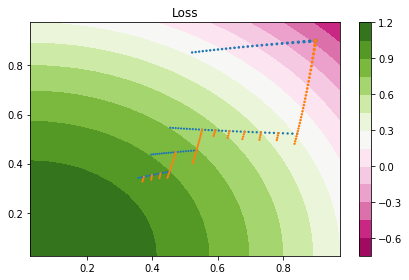

In [259]:
population = ExamplePopulation()

population.evolve(100)

plot_population(population)
